In [4]:
import numpy as np  
import matplotlib.pyplot as plt  
  
from keras.models import Sequential  
from keras.layers import Dense, Activation  
from keras.optimizers import SGD

In [27]:
%matplotlib inline

In [9]:
# the dimensionality of x vectors   
Dx = 2    
Cy = 8  
  # pick Py randomly, each entry from 1..5, then normalize  
Py = np.random.choice(range(1,4), Cy)  

In [20]:
# the dimensionality of x vectors   
Dx = 2    
# the cardinality of y   
Cy = 8    
# pick Py randomly, each entry from 1..5, then normalize  
Py = np.random.choice(range(1,4), Cy)  
Py = Py/float(sum(Py))
# # pick the A parameters   
A = np.random.uniform(0, 10, [Dx+1, Cy])  
  
# # # number of samples   
N=10000  
  
# # # Generate the samples    
Y= np.random.choice(Cy, N, p=Py)  
T= np.zeros([N, Dx+1])  
  
for j in range(Cy):  
    T[Y==j, :] = np.random.dirichlet(A[:, j], sum(Y==j))  

X = T[:, :-1]  
  
# # # make the labels  
Labels=np.zeros([N, Cy]) # neural network takes the indicators instead of Y      
for i in range(N):  
    Labels[i, Y[i]]=1  
# # # centralize       
Xbar=sum(X)/float(N)
X=X-np.tile(Xbar, [N,1])  

In [21]:
model=Sequential()  
model.add(Dense(Cy, activation='softmax', input_dim=Dx))  
  
sgd = SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)  
model.compile(loss='categorical_crossentropy',  optimizer=sgd,  metrics=['accuracy'])
model.fit(X, Labels, verbose=0, epochs=200, batch_size=200)

In [33]:
model.get_weights()[0]


# empirical distribution of Y, we are not supposed to know Py anyway
PPy=sum(Labels)/N  

# compute the empirical means M[j,:] = E[ X | Y=j ] 
M=np.zeros([Cy, Dx])  
for j in range(Cy):  
    M[j,:] = sum(X[Y==j, :])/sum(Y==j) 

In [34]:
def regulate(x, p):  
    ''' 
    regulate x vector so it has zero mean and unit variance w.r.t. p 
    '''  
    assert(np.isclose(sum(p),1)), 'invalid distribution used in regulate()'  
    assert(x.size==p.size), 'dimension mismatch in regulate()'  
     
    x = x.reshape(x.size)
    r = x - sum(x*p)  
    r = r / np.sqrt(sum(p*r*r))  
    return(r)

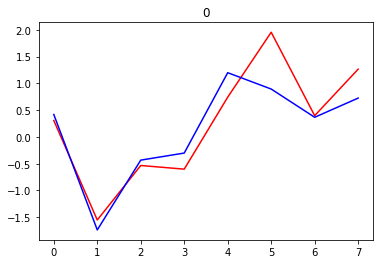

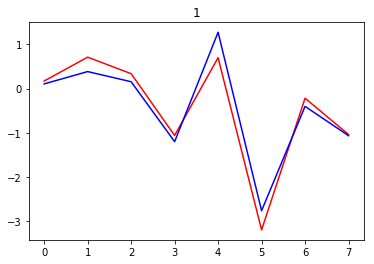

In [50]:
for i in range(Dx):  
    plt.figure(i)  
    plt.plot(range(Cy), regulate(M[:, i], PPy), 'r-')  
    plt.plot(range(Cy), regulate(model.get_weights()[0][i], PPy), 'b-')  
    plt.title(i)  
    plt.show()

In [51]:
def Generate2DSamples(xCard, yCard, nSamples):
    
    # randomly pick joint distribution, normalize
    Pxy = np.random.random([xCard, yCard])
    Pxy = Pxy / sum(sum(Pxy))

    # compute marginals
    Px = np.sum(Pxy, axis=1)
    Py = np.sum(Pxy, axis=0)    
    
    lp = np.reshape(Pxy, xCard*yCard)
        
    data = np.random.choice(range(xCard*yCard), nSamples, p=lp)
    
    X = (data/yCard).astype(np.int) 
    Y = data % yCard
    
    return([Pxy, Px, Py, X, Y])


xCard = 8
yCard = 6
nSamples = 100000

[Pxy, Px, Py, X, Y] = Generate2DSamples(xCard, yCard, nSamples)

In [58]:
from sklearn.preprocessing import OneHotEncoder

In [59]:
def MakeLabels(X):
    onehot_encoder = OneHotEncoder(sparse=False)
    temp = X.reshape(len(X), 1)
    onehots = onehot_encoder.fit_transform(temp)  # array [len(x), xCard]
    return(onehots)

XLabels = MakeLabels(X)
YLabels = MakeLabels(Y)

In [61]:
model = Sequential()
model.add(Dense(1, activation='sigmoid', input_dim=xCard))
model.add(Dense(yCard, activation='softmax', input_dim=1))

sgd = SGD(4, decay=1e-2, momentum=0.9, nesterov=True)
model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])
model.fit(XLabels, YLabels, verbose=0, batch_size=nSamples, epochs=100) 

weights = model.get_weights()

In [63]:
weights

[array([[ 0.2146045 ],
        [-1.40276456],
        [ 0.44849128],
        [ 2.81332779],
        [-1.7275933 ],
        [-2.61807346],
        [ 2.0223608 ],
        [ 0.76709515]], dtype=float32),
 array([ 0.38429072], dtype=float32),
 array([[-1.03274727, -1.60265243, -2.1249876 ,  2.24496317, -0.2978662 ,
          1.40720451]], dtype=float32),
 array([ 0.7040863 ,  0.66682786,  0.88763356, -1.78491175,  0.36499771,
        -0.83867043], dtype=float32)]